## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [2]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import torch.distributed as dist
import datetime
from collections import namedtuple
sys.path.insert(0, '../')
import deca_dpm
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_img_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
    seed_all,
    diffusion_defaults,
)

In [3]:
def create_argparser(log_dir, img_model_path, image_size, in_ch, out_ch, **kwargs):
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=1,
        use_ddim=False,
        img_model_path=img_model_path,
        log_dir=log_dir,
        diffusion_step=1000,
        timestep_respacing=1000,
        image_size=image_size,
        in_image="raw",
        deca_cond=False,
        bound=1,
    )

    defaults.update(model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch))
    return namedtuple('GenericDict', defaults.keys())(**defaults)

def model_and_diffusion_defaults(image_size, in_ch, out_ch):
    """
    Defaults for image training.
    """
    res = dict(
        image_size=image_size,
        num_channels=128,
        in_channels=in_ch,
        out_channels=out_ch,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        deca_cond=True
    )
    res.update(diffusion_defaults())
    return res

In [4]:
# List model_logs
ct = ""
# sshfs_path = "/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/Mint/Work/Vision/Diffusion/mount/"
sshfs_path = "/home2/mint/model_logs"
model_logs_path = f"{sshfs_path}/{ct}/"

# args
log_dir = "flower_1k_rgb"

step = "400000"
# ckpt = f"model{step}"
ckpt = f"ema_0.9999_{step}"
img_model_path = f"{model_logs_path}/{log_dir}/{ckpt}.pt"

image_size=64
in_ch = 3
out_ch = 3
args = create_argparser(log_dir=log_dir, img_model_path=img_model_path, image_size=image_size, in_ch=in_ch, out_ch=out_ch)

# Check model_logs
if not os.path.isdir(os.path.join(model_logs_path, args.log_dir)):
    print("No logs folder")
    raise FileNotFoundError
else: 
    if not os.path.isdir(os.path.join(model_logs_path, args.log_dir, "samples")):
        os.makedirs(os.path.join(model_logs_path, args.log_dir, "samples"))

if args.in_image in ['raw', 'raw+uvdn']:
    model_and_diffusion = model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch)
    print("creating {} model and diffusion...".format(args.in_image))
else:
    raise NotImplementedError

img_model, diffusion = create_img_and_diffusion(
    **args_to_dict(args, model_and_diffusion.keys())
)


img_model.load_state_dict(
    th.load(args.img_model_path, map_location="cpu")
)

img_model.to('cuda')
img_model.eval()


creating raw model and diffusion...


UNetModelDECA(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), 

In [5]:
def decolor(s, out_c='rgb'):
    if out_c in ['rgb', 'rbg', 'brg', 'bgr', 'grb', 'gbr']:
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'luv':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'ycrcb':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c in ['hsv', 'hls']:
        h = (s[..., [0]] + 1) * 90.0 
        l_s = (s[..., [1]] + 1) * 127.5
        v = (s[..., [2]] + 1) * 127.5
        s_ = th.cat((h, l_s, v), axis=2).clamp(0, 255).to(th.uint8)
    elif out_c == 'sepia':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)

    else: raise NotImplementedError

    return s_

def plot_sample(img, **kwargs):
    columns = 6
    rows = 10
    fig = plt.figure(figsize=(20, 20), dpi=100)
    img = img.permute(0, 2, 3, 1) # BxHxWxC
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = decolor(s=img[i], out_c='rgb')
        s_ = s_.detach().cpu().numpy()
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = decolor(s=kwargs[k][i].permute(1, 2, 0), out_c='rgb')
                s_ = s_.detach().cpu().numpy()
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()
        

In [6]:
import pytorch_lightning as pl
class PLInference(pl.LightningModule):
    def __init__(self, img_model, sample_fn):
        super(PLInference, self).__init__()
        self.img_model = img_model
        self.sample_fn = sample_fn
        self.deca_dpm = deca_dpm.Diffusion_DECA(model=self.img_model, diffusion=diffusion, bound=args.bound, progress=True)

    def forward(self):
        seed_all(33)
        if self.sample_fn == 'p_sample_loop':
            image_output = self.deca_dpm.p_sample_loop(
                                        shape_dict={'deca':(args.batch_size, args.out_channels, args.image_size, args.image_size)})

        return {"image_output":image_output}

pl_inference = PLInference(img_model=img_model, sample_fn='p_sample_loop')
sample = pl_inference()

  0%|          | 0/1000 [00:00<?, ?it/s]

999 tensor(3.8801, device='cuda:0', dtype=torch.float64) tensor(-3.6874, device='cuda:0', dtype=torch.float64)
998 tensor(3.9401, device='cuda:0', dtype=torch.float64) tensor(-3.8008, device='cuda:0', dtype=torch.float64)
997 tensor(3.9572, device='cuda:0', dtype=torch.float64) tensor(-3.7645, device='cuda:0', dtype=torch.float64)
996 tensor(4.0313, device='cuda:0', dtype=torch.float64) tensor(-3.8153, device='cuda:0', dtype=torch.float64)
995 tensor(4.1564, device='cuda:0', dtype=torch.float64) tensor(-3.7743, device='cuda:0', dtype=torch.float64)
994 tensor(3.8845, device='cuda:0', dtype=torch.float64) tensor(-3.6884, device='cuda:0', dtype=torch.float64)
993 tensor(3.7232, device='cuda:0', dtype=torch.float64) tensor(-3.8628, device='cuda:0', dtype=torch.float64)
992 tensor(3.8859, device='cuda:0', dtype=torch.float64) tensor(-3.9124, device='cuda:0', dtype=torch.float64)
991 tensor(3.6949, device='cuda:0', dtype=torch.float64) tensor(-3.8787, device='cuda:0', dtype=torch.float64)
9

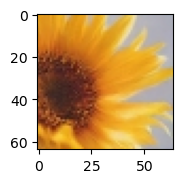

In [7]:
B, C, _, _ = sample["image_output"].shape
if C == 6:
    plot_sample(sample["image_output"][:, :3, ...], uvdn=sample["img_output"][:, 3:, ...])
else :
    plot_sample(sample["image_output"][:, :3, ...])

  0%|          | 0/1000 [00:00<?, ?it/s]

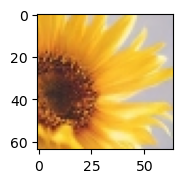

In [8]:
import pytorch_lightning as pl
class PLInference(pl.LightningModule):
    def __init__(self, img_model, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.img_model=img_model
        self.deca_model=deca_model
        self.sample_fn = sample_fn

    def forward(self):
        seed_all(33)
        sample = self.sample_fn(
            model=self.img_model,
            shape=(args.batch_size, in_ch, args.image_size, args.image_size),
            clip_denoised=args.clip_denoised,
        )
        return sample

pl_inference = PLInference(img_model=img_model, deca_model=img_model, sample_fn=diffusion.p_sample_loop)
sample = pl_inference()
plot_sample(sample)